## Import Library

In [26]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [27]:
print(os.listdir("../input"))

['real-and-fake-face-detection', 'celeba-dataset', 'animefacedataset', 'cartoonset10k']


In [28]:
real = "../input/real-and-fake-face-detection/real_and_fake_face/training_real/"
fake = "../input/real-and-fake-face-detection/real_and_fake_face/training_fake/"
cartoon="/kaggle/input/cartoonset10k/cartoonset10k"
anime="/kaggle/input/animefacedataset/images"
celeba="/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
real_path = os.listdir(real)
fake_path = os.listdir(fake)


In [5]:
# import os

# # Define the path to the file
# # file_path = '/kaggle/working/output.txt'
# #  save
# real_path_file = 'training_real_path'
# fake_path_file = 'training_fake_path'

# file_path=fake_path_file
# # Check if the file exists
# if os.path.exists(file_path):
#     # Delete the file
#     os.remove(file_path)
#     print('File deleted successfully.')
# else:
#     print('File not found.')


## Merging of different Type of Images

In [29]:
cartoon_fake_path=os.listdir(cartoon)[:10000]
anime_fake_path=os.listdir(anime)[:15000]
celeba_real_path=os.listdir(celeba)[29000:59000]
training_real = os.listdir(real)
training_fake= os.listdir(fake)

In [14]:
os.makedirs('/kaggle/working/final_fake')
os.makedirs('/kaggle/working/final_real')


In [15]:
import shutil

target = '/kaggle/working/final_fake'
real_target = '/kaggle/working/final_real'
for file_name in cartoon_fake_path:
   shutil.copy(cartoon+'/'+file_name, target+'/'+file_name)
for file_name in anime_fake_path:
   shutil.copy(anime+'/'+file_name, target+'/'+file_name)
for file_name in training_fake:
   shutil.copy(fake+'/'+file_name, target+'/'+file_name)
for file_name in celeba_real_path:
   shutil.copy(celeba+'/'+file_name, real_target+'/'+file_name)
for file_name in training_real:
   shutil.copy(real+'/'+file_name, real_target+'/'+file_name)



In [ ]:
# real_path
path=[cartoon,anime,celeba]
for i in real_path:
    if(i in os.listdir(cartoon) or i in os.listdir(anime)):
        


In [25]:
print(len(real_path))
print(len(fake_path))

1081
960


In [51]:
import os

# Define the path to the Kaggle notebook directory
kaggle_dir = '/kaggle/working/'

# Define the names of the files you want to save
real_path_file = 'training_real_path.txt'
fake_path_file = 'training_fake_path.txt'

# # Define the contents of the lists
# real_path = ['path1', 'path2', 'path3']
# fake_path = ['path4', 'path5', 'path6']

# Write the contents of the lists to the files
with open(os.path.join(kaggle_dir, real_path_file), 'w') as f:
    f.write('\n'.join(real_path))
    
with open(os.path.join(kaggle_dir, fake_path_file), 'w') as f:
    f.write('\n'.join(fake_path))


In [50]:
kaggle_dir = '/kaggle/working/'

# Define the name of the folder you want to create
folder_name = 'training'

# Create the folder if it doesn't already exist
if not os.path.exists(os.path.join(kaggle_dir, folder_name)):
    os.makedirs(os.path.join(kaggle_dir, folder_name))

## Visulaizing the real and fake faces

In [30]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(220, 220))
    return image[...,::-1]

In [32]:
# dataset_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face"
dataset_path="/kaggle/working/"

## Data augumentation

In [33]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [34]:
data_path="/kaggle/working/"

In [35]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")
# train = data_with_aug.flow_from_directory(real_path,
#                                           class_mode="binary",
#                                           target_size=(96, 96),
#                                           batch_size=32,
#                                           subset="training")

Found 45633 images belonging to 2 classes.


In [36]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 11408 images belonging to 2 classes.


## MobileNetV2

In [37]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9412608/9406464 [==============================] - 0s 0us/step


In [38]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Callbacks

In [39]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/20
52/52 [==============================] - 27s 514ms/step - loss: 0.9166 - accuracy: 0.5836 - val_loss: 0.9865 - val_accuracy: 0.5245
Epoch 2/20
52/52 [==============================] - 20s 393ms/step - loss: 0.5778 - accuracy: 0.6895 - val_loss: 1.1129 - val_accuracy: 0.5074
Epoch 3/20
52/52 [==============================] - 21s 397ms/step - loss: 0.4562 - accuracy: 0.7851 - val_loss: 1.0288 - val_accuracy: 0.5196
Epoch 4/20
52/52 [==============================] - 21s 394ms/step - loss: 0.3560 - accuracy: 0.8426 - val_loss: 0.9568 - val_accuracy: 0.5417
Epoch 5/20
52/52 [==============================] - 21s 395ms/step - loss: 0.3357 - accuracy: 0.8598 - val_loss: 1.0022 - val_accuracy: 0.5319
Epoch 6/20
52/52 [==============================] - 20s 389ms/step - loss: 0.3112 - accuracy: 0.8677 - val_loss: 1.0332 - val_accuracy: 0.5343
Epoch 7/20
52/52 [==============================] - 20s 379ms/step - loss: 0.3070 - accuracy: 0.8702 - val_loss: 1.0161 - val_accuracy: 0.5392

In [1]:
from keras.preprocessing.image import load_img, img_to_array
# test="/kaggle/input/animefacedataset/images/10006_2004.jpg"
test="/kaggle/input/animefacedataset/images/10005_2004.jpg"
# test="/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000006.jpg"
# Load the image from its path and resize it to match the input size of the model
img = load_img(test, target_size=(224, 224))

# Convert the image to a NumPy array and scale the pixel values to be between 0 and 1
img_array = img_to_array(img) / 255.0

# Reshape the array to have a batch dimension of 1
img_array = img_array.reshape((1,) + img_array.shape)
#   preds= model.predict(x)

# Make the prediction using the model's predict() method
prediction = model.predict(img_array)

# The prediction will be an array of predicted values for the input image
# You can then use this prediction for further analysis or to determine if the image is fake or not


NameError: name 'model' is not defined

In [90]:
prediction

array([[9.9998808e-01, 1.1976344e-05]], dtype=float32)

In [89]:
prediction[0][1]>prediction[0][0]

False

In [59]:
# def model_predict(img_path, model): 
#   img = load_img(img_path, target_size=(100,100))  
#     #   plt.imshow(img)
#   x = img_to_array(img) 
#   x = x.astype('float16') 
#   x /= 255
#   x = np.expand_dims(x, axis=0)
#   preds= model.predict(x)
#   return preds

In [54]:
prediction

array([[0.7701489 , 0.22985111]], dtype=float32)

In [81]:
def model_predict(img_path, model): 
  img = load_img(img_path, target_size=(100,100))
    #   plt.imshow(img)
  x = img_to_array(img) 
  x = x.astype('float16') 
  x /= 255
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
    #   answer = np.argmax(preds)
    #   print(mapper[answer])
  return preds

SyntaxError: invalid character in identifier (<ipython-input-81-9734f1b0e924>, line 11)

In [21]:
test="/kaggle/input/cartoonset10k/cartoonset10k/cs10000053986926948907.png"
predictions = model.model_predict(val)


In [22]:
val

## Visualising the accuracy and loss

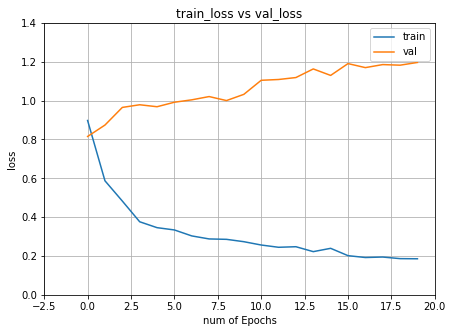

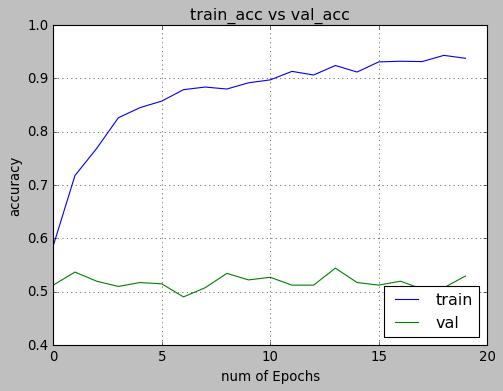

In [18]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

## Trying VGG16 model

In [62]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 45633 images belonging to 2 classes.
Found 11408 images belonging to 2 classes.


In [63]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58892288/58889256 [==============================] - 3s 0us/step


In [64]:
vgg16_model.output[-1]

<tf.Tensor 'strided_slice:0' shape=(7, 7, 512) dtype=float32>

In [65]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [66]:
hist =  model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/20
466/466 [==============================] - 225s 483ms/step - loss: 0.0727 - accuracy: 0.9737 - val_loss: 0.0046 - val_accuracy: 0.9997
Epoch 2/20
466/466 [==============================] - 223s 478ms/step - loss: 0.0449 - accuracy: 0.9829 - val_loss: 0.0051 - val_accuracy: 0.9992
Epoch 3/20
466/466 [==============================] - 224s 481ms/step - loss: 0.0385 - accuracy: 0.9852 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 4/20
466/466 [==============================] - 222s 477ms/step - loss: 0.0222 - accuracy: 0.9906 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 5/20
466/466 [==============================] - 223s 478ms/step - loss: 0.0203 - accuracy: 0.9917 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 6/20
466/466 [==============================] - 223s 478ms/step - loss: 0.0185 - accuracy: 0.9923 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 7/20
466/466 [==============================] - 223s 479ms/step - loss: 0.0176 - accuracy: 0.9931 - val_loss: 0.0022 -

## Visualising the accuracy and loss

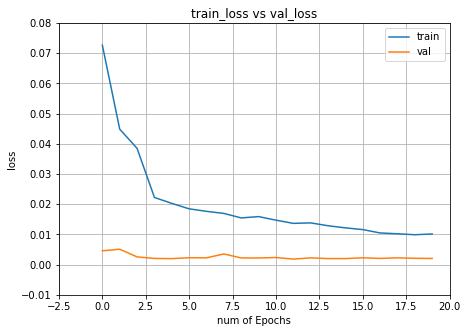

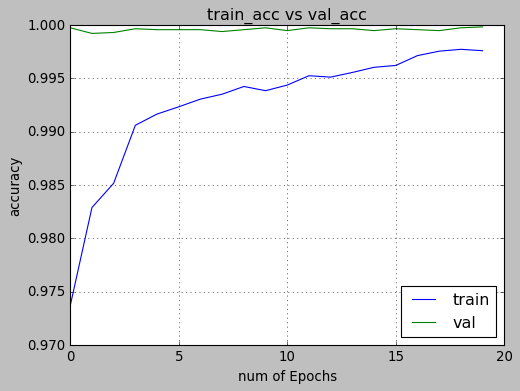

In [67]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

## Predictions

In [70]:
#Creating an array of predicted test images

predictions = model.predict_generator(val)

In [75]:
model.save("Real_vs_fake_detection.h5")

In [80]:
model_predict('/kaggle/input/cartoonset10k/cartoonset10k/cs10000983636605150156.png',model)

NameError: name 'model_predict' is not defined

In [76]:
predictions

array([[9.9622619e-01, 3.7738197e-03],
       [1.1494970e-03, 9.9885046e-01],
       [5.5095187e-04, 9.9944907e-01],
       ...,
       [8.6283255e-03, 9.9137163e-01],
       [9.9999952e-01, 4.7023889e-07],
       [3.5411361e-04, 9.9964583e-01]], dtype=float32)

In [ ]:
val

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cartoonset10k/cartoonset10k/cs10000053986926948907.pngfinal_fake/1097_2001.jpg'

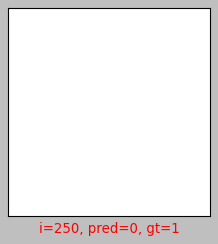

In [78]:
# val_path = "/kaggle/input/cartoonset10k/cartoonset10k/cs10000053986926948907.png"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()